<a href="https://colab.research.google.com/github/let-aranha/ttc-bi-master/blob/main/Classifica%C3%A7%C3%A3o_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/TCC/Data'
os.chdir(workdir_path)

Mounted at /content/drive


In [2]:
#Importando bibliotecas

# Lib JSON
import json 
import pandas as pd
import numpy as np

# Lib dados em formato data
from datetime import datetime

# Lib para criação e gráficos
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lib para divisão base treino e teste
from sklearn.model_selection import train_test_split

# Lib para visualização de missing values
import missingno as msno


In [3]:
# Importando json file direto para o notebook

# import json 
# import pandas as pd
# import numpy as np

# Opening JSON file 
f = open('tickets_anonymized_Rev2.json', encoding='utf-8') 

# returns JSON object as 
# a dictionary 
data = json.load(f) 

# Iterating through the json 
# list 
# for i in data: 
# 	print(i) 

# Closing file 
f.close() 

In [4]:
# Convertendo dados em DataFrame

tickets = pd.DataFrame(data)
tickets.head()

,id,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating
0,162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None
1,166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None
2,182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None
3,189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None
4,207873,2019-12-09T13:54:47.000Z,None,normal,open,True,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None


In [5]:
tickets.shape

(22653, 18)

In [6]:
tickets.set_index('id', inplace = True)
tickets.head(2)

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating
id,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None


# ETL

#### 'created_at'

In [7]:
# Criando variável para dia da semana
# Onde 0 é segunda-feira e 6 é domingo

weekday = []

for i in tickets['created_at']:
  weekday.append((datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date()).weekday())

tickets['weekday'] = weekday
tickets.head()

,created_at,type,priority,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday
id,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,incident,high,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2
166035,2019-06-12T15:23:14.000Z,incident,high,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2
182449,2019-08-23T21:13:47.000Z,question,normal,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4
189041,2019-09-20T16:33:59.000Z,incident,normal,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4
207873,2019-12-09T13:54:47.000Z,None,normal,open,True,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0


#### 'type' e 'priority'

In [8]:
# Valores únicos em variável type

tickets['type'].unique()

array(['incident', 'question', None, 'task', 'problem'], dtype=object)

In [9]:
# Transformando variável categórica com One Hot Encoding
types = pd.get_dummies(tickets.type, prefix = 'type', drop_first = False)
types.head()

# OBS: Não descarta a primeira em função dos Nones

,type_incident,type_problem,type_question,type_task
id,,,,
162875,1,0,0,0
166035,1,0,0,0
182449,0,0,1,0
189041,1,0,0,0
207873,0,0,0,0


In [10]:
# Valores únicos em variável priority

tickets.priority.unique()

array(['high', 'normal', 'urgent', 'low'], dtype=object)

In [11]:
# Transformando variável categórica com One Hot Encoding
priorities = pd.get_dummies(tickets.priority, prefix = 'priority', drop_first = True)
priorities.head()

,priority_low,priority_normal,priority_urgent
id,,,
162875,0,0,0
166035,0,0,0
182449,0,1,0
189041,0,1,0
207873,0,1,0


In [12]:
# Dando merge nos DataFrames e excluindo as variáveis originais
frames = [tickets,types,priorities]
tickets = pd.concat(frames,axis=1)
tickets = tickets.drop(['priority','type'], axis=1)
tickets.head()

,created_at,status,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent
id,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,hold,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0
166035,2019-06-12T15:23:14.000Z,open,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0
182449,2019-08-23T21:13:47.000Z,hold,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0
189041,2019-09-20T16:33:59.000Z,solved,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0
207873,2019-12-09T13:54:47.000Z,open,True,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0


#### 'status'

In [13]:
# Em função do status ser uma condição do ticket que altere conforme existem as interações por parte dos agentes, e o algoritmo
# atuará apenas nos tickets com status 'New', a coluna em questão será descartada.

tickets = tickets.drop(['status'], axis=1)
tickets.head()

,created_at,is_public,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent
id,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,True,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0
166035,2019-06-12T15:23:14.000Z,True,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0
182449,2019-08-23T21:13:47.000Z,True,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0
189041,2019-09-20T16:33:59.000Z,True,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0
207873,2019-12-09T13:54:47.000Z,True,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0


#### 'is_public'

In [14]:
# Apenas tickets públicos são válidos para esse algoritmo

unique, counts = np.unique(tickets['is_public'], return_counts=True)
print(f'Total de {unique[0]}: {counts[0]}')
print(f'Total de {unique[1]}: {counts[1]}')


Total de False: 3247
Total de True: 19406


In [15]:
# Descartando valores "False"

tickets = tickets[tickets['is_public'] == True]

In [16]:
tickets.shape

(19406, 22)

In [17]:
# Descartando atributo

tickets = tickets.drop(['is_public'], axis=1)
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent
id,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0


#### 'requester_id' igual à 'submitter_id'

In [18]:
# Criar dado para 'requester_id' igual à 'submitter_id"

# Para quando o requester e o submitter são iguais, o valor é 0
# Para quando o requester e o submiter são diferentes, o valor é 1

data = []

for i in tickets.index:
  if tickets.loc[i,'requester_id'] == tickets.loc[i,'submitter_id']:
    data.append(0)
  else:
    data.append(1)

tickets['requester_equal_submitter'] = data
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0,0
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,False,False,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0,0
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,False,False,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0,0
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,True,False,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0,0
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,False,False,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0,0


#### 'has_partner' e 'has_success_manager'

In [19]:
tickets['has_partner'] = tickets['has_partner'].replace({True: 1, False: 0})

In [20]:
tickets['has_success_manager'] = tickets['has_success_manager'].replace({True: 1, False: 0})

In [21]:
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter
id,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0,0
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0,0
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0,0
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0,0
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0,0


#### 'requester_created_at'

In [22]:
# Calculando tempo de duração do requester com base na data de criação menos data de abertura do ticket


creationUser = []
for i in tickets['requester_created_at']:
    creationUser.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date())

creationTicket = []
for i in tickets['created_at']:
    creationTicket.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z').date())
    
duration_days = []
for i in range(len(creationUser)):
    duration_days.append((creationTicket[i]-creationUser[i]).days)

# Incluindo nova coluna ao DataFrame com dados de duração dos tickets
tickets['requester_duration_days'] = duration_days
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,requester_nps,requester_platform_skills,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days
id,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,high,None,2,1,0,0,0,0,0,0,0,1029
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,nps-detractor,platform-skills-advanced,very_high,None,2,1,0,0,0,0,0,0,0,1043
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,2019-04-04T13:34:21.000Z,None,platform-skills-advanced,very_high,None,4,0,0,1,0,0,1,0,0,141
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,2019-03-18T20:21:53.000Z,None,platform-skills-intermediate,moderate,None,4,1,0,0,0,0,1,0,0,186
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,2018-07-25T06:41:31.000Z,None,platform-skills-advanced,None,None,0,0,0,0,0,0,1,0,0,502


#### One Hot Encoding para variáveis 'requester_nps' e 'requester_platform_skills'

In [23]:
# Valores únicos em variáveis

tickets['requester_nps'].unique()

array(['nps-detractor', None, 'nps-promoter', 'nps-passive'], dtype=object)

In [24]:
tickets['requester_platform_skills'].unique()

array(['platform-skills-advanced', 'platform-skills-intermediate',
       'platform-skills-beginner', None], dtype=object)

In [25]:
# Transformando variável categórica com One Hot Encoding
nps = pd.get_dummies(tickets.requester_nps, prefix = 'requester', drop_first = False)
nps.head()

,requester_nps-detractor,requester_nps-passive,requester_nps-promoter
id,,,
162875,1,0,0
166035,1,0,0
182449,0,0,0
189041,0,0,0
207873,0,0,0


In [26]:
plataformSkills = pd.get_dummies(tickets.requester_platform_skills, prefix = 'requester', drop_first = False)
plataformSkills.head()

,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate
id,,,
162875,1,0,0
166035,1,0,0
182449,1,0,0
189041,0,0,1
207873,1,0,0


In [27]:
# Dando merge nos DataFrames e excluindo as variáveis originais
frames = [tickets, nps, plataformSkills]
tickets = pd.concat(frames,axis=1)
tickets = tickets.drop(['requester_nps','requester_platform_skills'], axis=1)
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,high,None,2,1,0,0,0,0,0,0,0,1029,1,0,0,1,0,0
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,very_high,None,2,1,0,0,0,0,0,0,0,1043,1,0,0,1,0,0
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,2019-04-04T13:34:21.000Z,very_high,None,4,0,0,1,0,0,1,0,0,141,0,0,0,1,0,0
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,2019-03-18T20:21:53.000Z,moderate,None,4,1,0,0,0,0,1,0,0,186,0,0,0,0,0,1
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,2018-07-25T06:41:31.000Z,None,None,0,0,0,0,0,0,1,0,0,502,0,0,0,1,0,0


#### 'is_operating'

In [28]:
tickets['is_operating'].unique()

array([None, 'sf-account-isoperating-true',
       'sf-account-isoperating-false'], dtype=object)

In [29]:
# Tratando valores em 'is_operating'

tickets['is_operating'] = tickets['is_operating'].replace({'sf-account-isoperating-true': 1, 'sf-account-isoperating-false': 0})

In [30]:
tickets.head()

,created_at,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,requester_created_at,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,2019-05-29T11:47:31.000Z,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,high,NaN,2,1,0,0,0,0,0,0,0,1029,1,0,0,1,0,0
166035,2019-06-12T15:23:14.000Z,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,2016-08-03T15:18:13.000Z,very_high,NaN,2,1,0,0,0,0,0,0,0,1043,1,0,0,1,0,0
182449,2019-08-23T21:13:47.000Z,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,2019-04-04T13:34:21.000Z,very_high,NaN,4,0,0,1,0,0,1,0,0,141,0,0,0,1,0,0
189041,2019-09-20T16:33:59.000Z,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,2019-03-18T20:21:53.000Z,moderate,NaN,4,1,0,0,0,0,1,0,0,186,0,0,0,0,0,1
207873,2019-12-09T13:54:47.000Z,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,2018-07-25T06:41:31.000Z,None,NaN,0,0,0,0,0,0,1,0,0,502,0,0,0,1,0,0


### Criando variável 'created_at_business_hours'

In [31]:
# Intenção é tratar os dados de 'created_at' para identificar se foram criados entre às 09h e 18h

variavel = []

for i in tickets['created_at']:
  variavel.append(datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.000Z'))

In [32]:
# 0 para tickets criados fora do horário comercial
# 1 para tickets criados dentro do horário comercial
# OBS: tickets criados no sábado ou no domingo também são considerados fora do horário comercial

business_hours = []
horaInicial = (datetime.strptime('09:00:00', '%H:%M:%S').time())
horaFinal = (datetime.strptime('18:00:00', '%H:%M:%S').time())

for i in variavel:
  if i.weekday() == 5 or i.weekday() == 6:
    business_hours.append(0)
  else:
    if i.time() >= horaInicial and i.time() <= horaFinal:
      business_hours.append(1)
    else:
      business_hours.append(0)

In [33]:
# Incluindo nova variável no dataframe e excluíndo entradas de data originais

tickets['is_business_hours'] = business_hours
tickets = tickets.drop(['created_at','requester_created_at'], axis=1)
tickets.head()

,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,is_business_hours
id,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,high,NaN,2,1,0,0,0,0,0,0,0,1029,1,0,0,1,0,0,1
166035,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,very_high,NaN,2,1,0,0,0,0,0,0,0,1043,1,0,0,1,0,0,1
182449,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,very_high,NaN,4,0,0,1,0,0,1,0,0,141,0,0,0,1,0,0,0
189041,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,moderate,NaN,4,1,0,0,0,0,1,0,0,186,0,0,0,0,0,1,1
207873,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,None,NaN,0,0,0,0,0,0,1,0,0,502,0,0,0,1,0,0,1


# Análise Exploratória

In [34]:
# Importação dos pacotes

# import random
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

In [35]:
tickets.head()

,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,complexity,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,is_business_hours
id,,,,,,,,,,,,,,,,,,,,,,,,,,
162875,144968,8958433768,3.600088e+11,3.601459e+11,0.0,0.0,8958433768,high,NaN,2,1,0,0,0,0,0,0,0,1029,1,0,0,1,0,0,1
166035,144968,8958433768,3.600139e+11,3.601459e+11,0.0,0.0,8958433768,very_high,NaN,2,1,0,0,0,0,0,0,0,1043,1,0,0,1,0,0,1
182449,144968,379450971772,3.600155e+11,2.559354e+08,0.0,0.0,379450971772,very_high,NaN,4,0,0,1,0,0,1,0,0,141,0,0,0,1,0,0,0
189041,144968,378569033032,3.600120e+11,1.403345e+08,1.0,0.0,378569033032,moderate,NaN,4,1,0,0,0,0,1,0,0,186,0,0,0,0,0,1,1
207873,144968,367450009112,3.600124e+11,3.600242e+11,0.0,0.0,367450009112,None,NaN,0,0,0,0,0,0,1,0,0,502,0,0,0,1,0,0,1


In [36]:
# Tamanho da amostra

tickets.shape

(19406, 26)

In [37]:
tickets.describe()

,brand_id,submitter_id,group_id,organization_id,has_partner,has_success_manager,requester_id,is_operating,weekday,type_incident,type_problem,type_question,type_task,priority_low,priority_normal,priority_urgent,requester_equal_submitter,requester_duration_days,requester_nps-detractor,requester_nps-passive,requester_nps-promoter,requester_platform-skills-advanced,requester_platform-skills-beginner,requester_platform-skills-intermediate,is_business_hours
count,19406.0,1.940600e+04,1.930400e+04,1.565900e+04,15659.000000,15659.000000,1.940600e+04,18802.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000,19406.000000
mean,144968.0,3.717021e+11,3.595234e+11,2.516407e+11,0.159333,0.094131,3.712252e+11,0.674769,2.044059,0.042461,0.002164,0.605534,0.105174,0.420334,0.341338,0.050757,0.027826,415.791044,0.031073,0.036690,0.052252,0.118520,0.224003,0.393280,0.541740
std,0.0,8.731646e+10,1.320262e+10,1.589842e+11,0.365998,0.292020,8.798376e+10,0.468474,1.471245,0.201644,0.046473,0.488748,0.306785,0.493625,0.474171,0.219508,0.164480,425.256529,0.173519,0.188004,0.222540,0.323231,0.416935,0.488491,0.498268
min,144968.0,8.332444e+08,2.595627e+07,4.153510e+07,0.000000,0.000000,8.766956e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,144968.0,3.831173e+11,3.600047e+11,1.439846e+10,0.000000,0.000000,3.827546e+11,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,144968.0,3.982885e+11,3.600088e+11,3.604749e+11,0.000000,0.000000,3.982020e+11,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,267.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,144968.0,4.063185e+11,3.600120e+11,3.610705e+11,0.000000,0.000000,4.062662e+11,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,620.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,144968.0,4.130392e+11,3.600161e+11,3.613654e+11,1.000000,1.000000,4.130392e+11,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


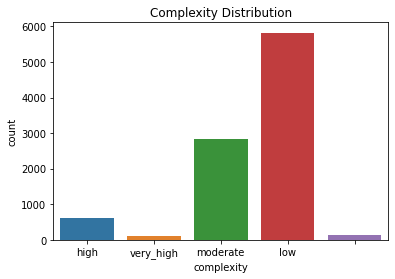

In [38]:
# Análise balanceamento

sns.countplot(data=tickets, x='complexity')
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Complexity Distribution')
plt.show()

In [39]:
# Analisando somatório de valores nulls na base de dados

tickets.isnull().sum()

brand_id                                     0
submitter_id                                 0
group_id                                   102
organization_id                           3747
has_partner                               3747
has_success_manager                       3747
requester_id                                 0
complexity                                9884
is_operating                               604
weekday                                      0
type_incident                                0
type_problem                                 0
type_question                                0
type_task                                    0
priority_low                                 0
priority_normal                              0
priority_urgent                              0
requester_equal_submitter                    0
requester_duration_days                      0
requester_nps-detractor                      0
requester_nps-passive                        0
requester_nps

In [40]:
# Limpando dados nulos da coluna de classificação

tickets = tickets.dropna(subset=['complexity'])

In [41]:
# Validando número de campos nulos na variável categórica

tickets['complexity'].isnull().sum()

0

In [42]:
# Contagem das classes de saída

unique, counts = np.unique(tickets['complexity'], return_counts=True)
print(f'Total de valores nulos: {counts[0]}')
print(f'Total de {unique[1]}: {counts[1]}')
print(f'Total de {unique[2]}: {counts[2]}')
print(f'Total de {unique[3]}: {counts[3]}')
print(f'Total de {unique[4]}: {counts[4]}')

Total de valores nulos: 130
Total de high: 613
Total de low: 5821
Total de moderate: 2845
Total de very_high: 113


In [43]:
# Descartando entradas com classe de saída nula

tickets = tickets[tickets['complexity'] != '']

In [44]:
tickets.shape

(9392, 26)

In [45]:
# Contagem das classes de saída

unique, counts = np.unique(tickets['complexity'], return_counts=True)
# print(f'Total de valores nulos: {counts[0]}')
print(f'Total de {unique[0]}: {counts[0]}')
print(f'Total de {unique[1]}: {counts[1]}')
print(f'Total de {unique[2]}: {counts[2]}')
print(f'Total de {unique[3]}: {counts[3]}')

# print(unique)

Total de high: 613
Total de low: 5821
Total de moderate: 2845
Total de very_high: 113


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


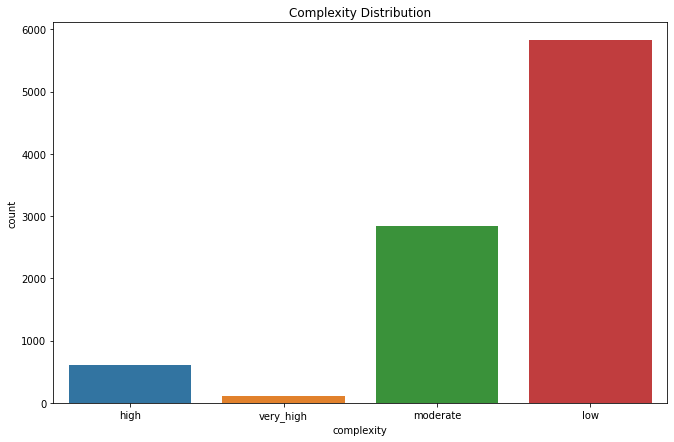

In [46]:
sns.countplot(tickets['complexity'])
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Complexity Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


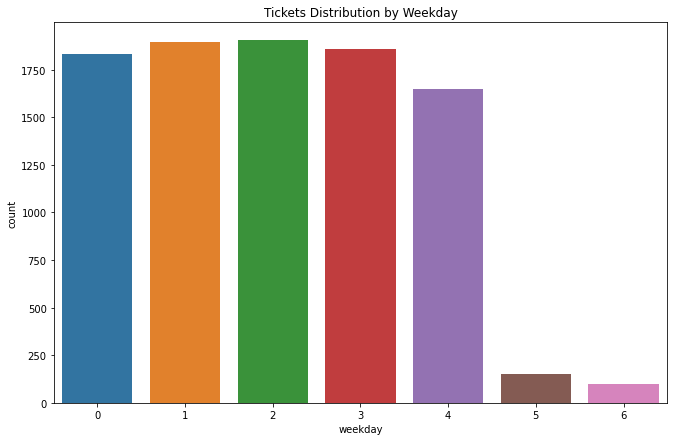

In [47]:
# Plotando gráfico da distribuição de tickets por dia da semana

sns.countplot(tickets['weekday'])
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Tickets Distribution by Weekday')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


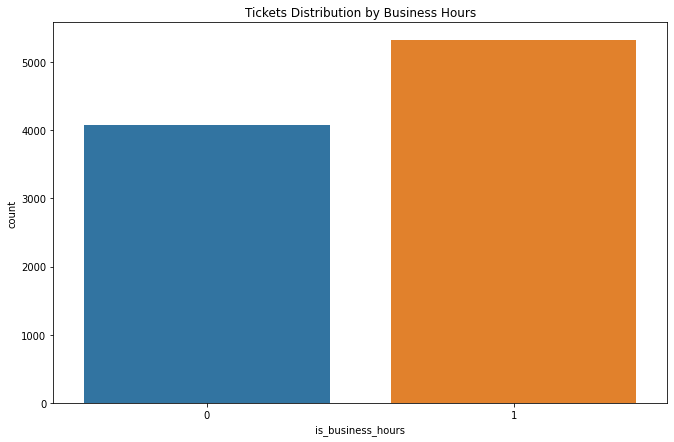

In [48]:
# Plotando gráfico da distribuição de tickets por variável de business_hours

sns.countplot(tickets['is_business_hours'])
plt.rcParams['figure.figsize'] = (11,7)
plt.title('Tickets Distribution by Business Hours')
plt.show()

# Separando Input e Output

In [49]:
# semente para reprodução de resultados
seed=10000

# Separando base de treino e de teste
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tickets.loc[:,tickets.columns != 'complexity'],
                                                    tickets['complexity'], test_size=0.2, stratify=tickets['complexity'],
                                                    random_state=seed)

print('shape input de treino: ', x_train.shape)
print('shape input de teste: ', x_test.shape)
print('shape output de treino: ', y_train.shape)
print('shape output de teste: ', y_test.shape)

shape input de treino:  (7513, 25)
shape input de teste:  (1879, 25)
shape output de treino:  (7513,)
shape output de teste:  (1879,)


In [50]:
# Verificar proporções. Amostragem estratificada

tickets['complexity'].value_counts()

low          5821
moderate     2845
high          613
very_high     113
Name: complexity, dtype: int64

In [51]:
#treino
print(0.8 * tickets['complexity'].value_counts()[0])
print(0.8 * tickets['complexity'].value_counts()[1])
print(0.8 * tickets['complexity'].value_counts()[2])
print(0.8 * tickets['complexity'].value_counts()[3])

#teste
print(0.2 * tickets['complexity'].value_counts()[0])
print(0.2 * tickets['complexity'].value_counts()[1])
print(0.2 * tickets['complexity'].value_counts()[2])
print(0.2 * tickets['complexity'].value_counts()[3])

4656.8
2276.0
490.40000000000003
90.4
1164.2
569.0
122.60000000000001
22.6


In [52]:
y_train.value_counts()

low          4657
moderate     2276
high          490
very_high      90
Name: complexity, dtype: int64

In [53]:
y_test.value_counts()

low          1164
moderate      569
high          123
very_high      23
Name: complexity, dtype: int64

# Pré-Processamento

#### x_train

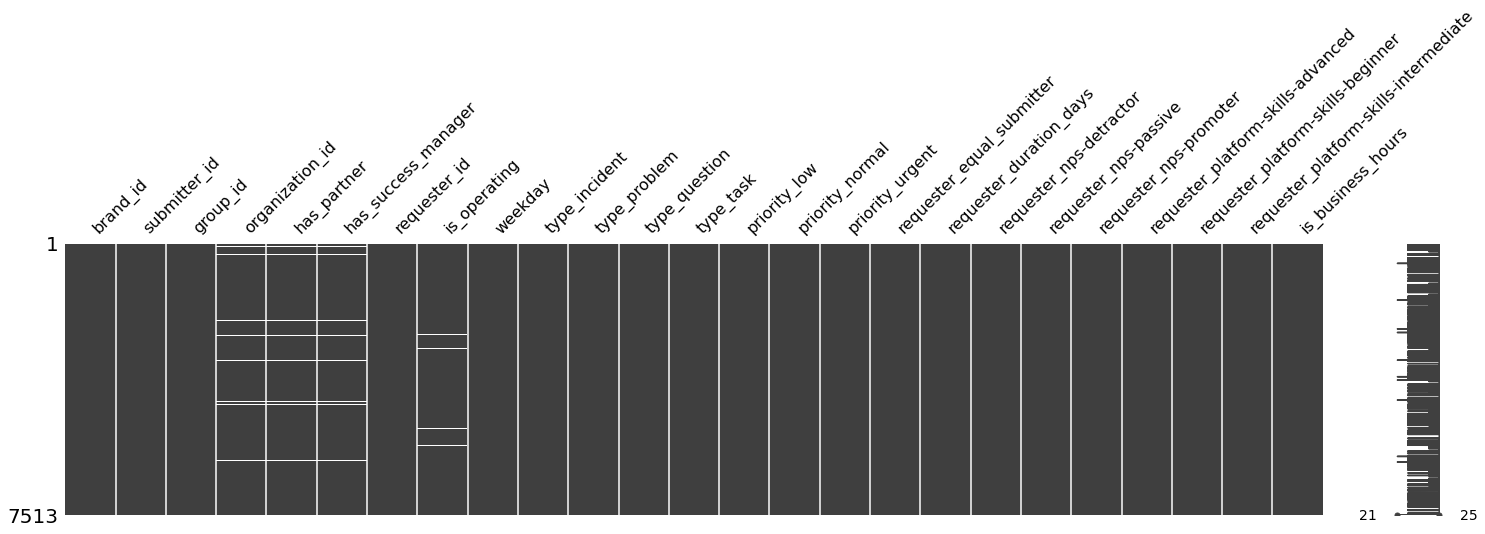

In [54]:
# Visualizar missing

# import missingno as msno
msno.matrix(x_train, figsize=(25,5));

In [60]:
# Verificar missing por linha

percent_missing_rows = x_train.apply(lambda x: x.isnull().sum() * 100 / len(x_train), axis=1).sort_values(ascending=False)
df = pd.DataFrame({'percent_missing': percent_missing_rows})
df.head()

,percent_missing
id,
334394,0.053241
330080,0.053241
329970,0.053241
333600,0.053241
330040,0.053241


In [59]:
# Verificar missing por coluna

percent_missing = x_train.apply(lambda x: x.isnull().sum() * 100 / len(x_train), axis=0).sort_values(ascending=False)
df = pd.DataFrame({'percent_missing': percent_missing})
df.head()

# Entender porque os nomes das colunas aparecem duas vezes e de forma divergente

,percent_missing
organization_id,4.112871
has_partner,4.112871
has_success_manager,4.112871
is_operating,1.850126
is_business_hours,0.000000


In [58]:
# Classe tem missing?

y_train.isnull().sum()

0

In [ ]:
# Atributos com muitos missing serão deletados

# att_to_delete = df[0:3].index.values
# att_to_delete

In [ ]:
# Deletar atributos

# x_train.drop(att_to_delete, axis=1, inplace=True)
# x_train.shape

# OBS: Atributos com maiores porcentagens de missing value é de 4% apenas

In [61]:
# Imputar dados faltantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [62]:
# Verificar se temos mais algum missing
print(np.isnan(x_train).sum())

0


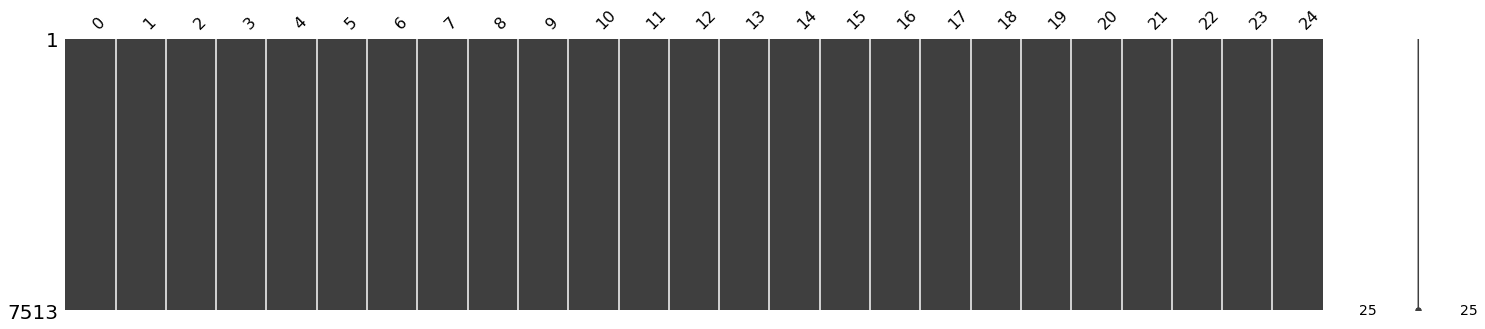

In [63]:
# visualizar novamente os missing
msno.matrix(pd.DataFrame(x_train), figsize=(25,5));

In [64]:
# remover colunas com variância zero
from sklearn.feature_selection import VarianceThreshold
zero_var_filter = VarianceThreshold()
x_train = zero_var_filter.fit_transform(x_train)

In [65]:
# colunas com variância zero
(zero_var_filter.variances_ == 0).sum()

1

In [66]:
# novo shape
pd.DataFrame(x_train).shape

(7513, 24)

#### x_test

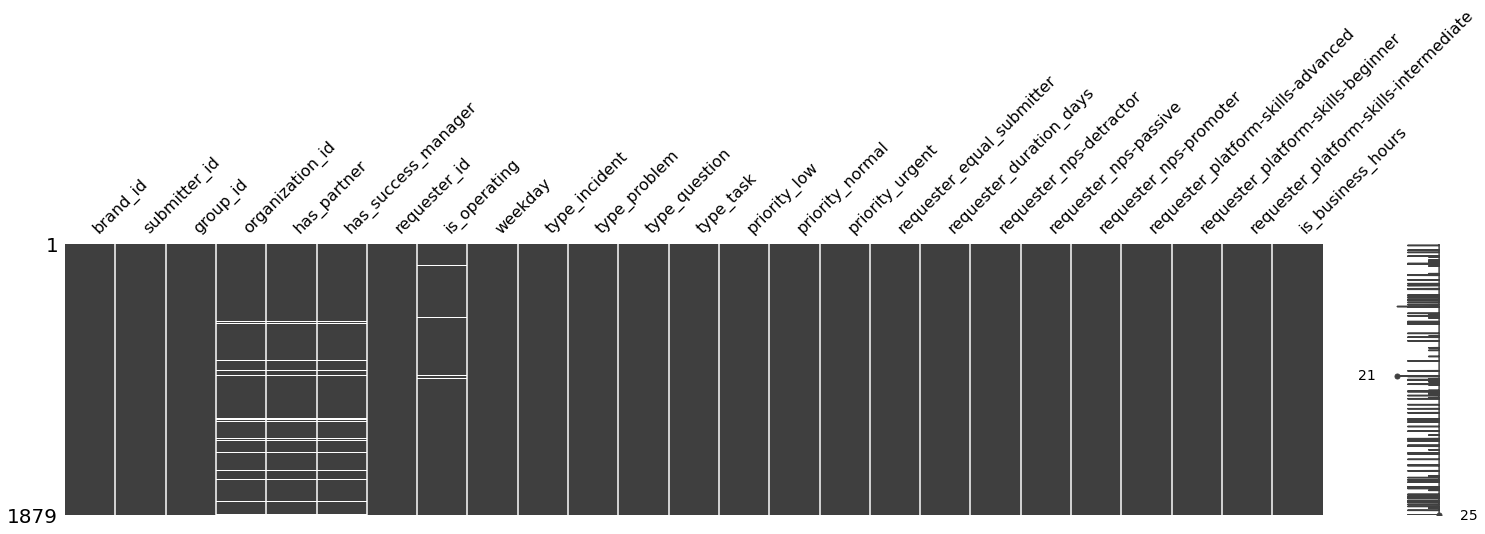

In [68]:
# Visualizar missing

msno.matrix(x_test, figsize=(25,5));

In [69]:
# Imputar dados faltantes
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="most_frequent")
# imputer.fit(x_train)
x_test = imputer.transform(x_test)

In [70]:
# Verificar se temos mais algum missing
print(np.isnan(x_test).sum())

0


In [71]:
# Remover colunas com variância zero

x_test = zero_var_filter.fit_transform(x_test)

In [72]:
# novo shape
pd.DataFrame(x_test).shape

(1879, 24)

# Árvore de Decisão

In [73]:
# treinar modelo
from sklearn.tree import DecisionTreeClassifier

def train(x_train, y_train, seed):
  model = DecisionTreeClassifier(min_samples_leaf=5, random_state=seed) # tente mudar parâmetro para evitar overfitting
  model.fit(x_train, y_train);
  return model

model = train(x_train, y_train, seed)

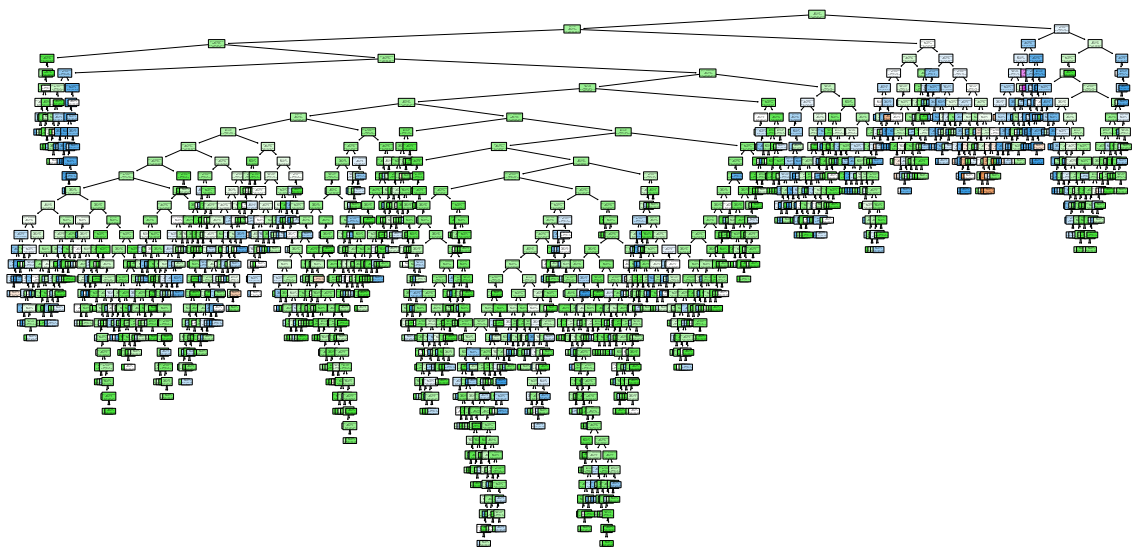

In [74]:
# Visualização gráfica da árvore de decisão
from sklearn import tree
fig, ax = plt.subplots(figsize=(20, 10)) # Definir tamanho da imagem a ser gerada
tree.plot_tree(model, class_names=['High', 'Very High', 'Moderate', 'Low'], filled=True, rounded=True); # plota a árvore

Acurácia:  0.5635976583288983
Kappa:  0.1278077166923286
F1:  0.5528424506911377


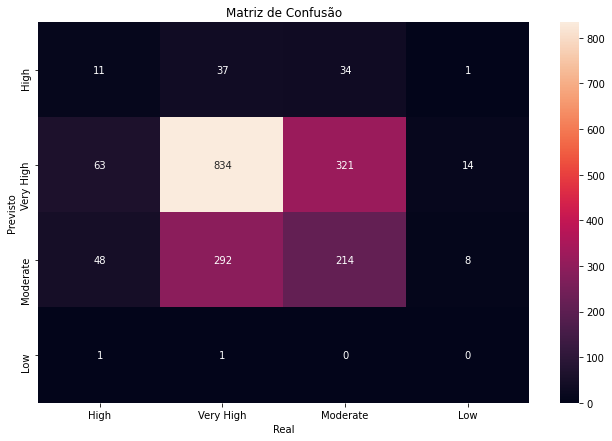

In [76]:
def predict_and_evaluate(x_test, y_test):

  y_pred = model.predict(x_test) #inferência do teste

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred, average = 'weighted')
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred, y_test)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f")
  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['High', 'Very High', 'Moderate', 'Low']) 
  ax.yaxis.set_ticklabels(['High', 'Very High', 'Moderate', 'Low'])
  plt.show()

predict_and_evaluate(x_test, y_test)